# Демонстрация автоматического расчета shap

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, base_pipe, PlotShap

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab
import shap

print('pandas: ', pd.__version__)
print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)
print('shap: ', shap.__version__)

pandas:  1.3.5
sklearn:  1.0.2
xgboost:  1.5.2
matplotlib:  3.5.1
autobinary:  1.0.7
shap:  0.40.0


In [5]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [9]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [10]:
# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(
    eta=0.01,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth = 6,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [11]:
xgb_model.fit(new_X_train, y_train);

[16:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 1. Использование библиотеки SHAP

In [12]:
# задаем класс
c_shap = PlotShap(model=xgb_model, sample=new_X_train)
# обучаем
c_shap.fit_shap()

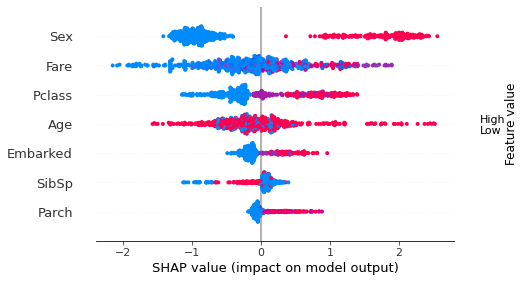

In [13]:
c_shap.create_plot_shap(plot_type='dot', number_features=30)

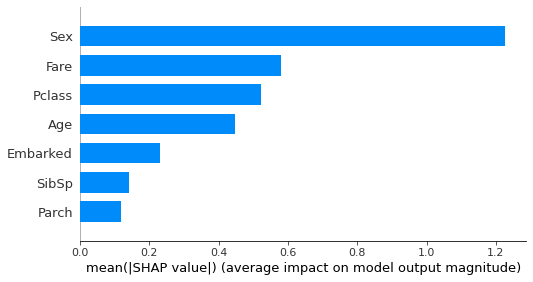

In [14]:
c_shap.create_plot_shap(plot_type='bar', number_features=30)

In [15]:
result = c_shap.get_table_shap()
result

,col_name,imp_shap
0,Sex,1.226701
1,Fare,0.580397
2,Pclass,0.522742
3,Age,0.446026
4,Embarked,0.231003
5,SibSp,0.141932
6,Parch,0.117993


## 2. График в нужном порядке
Часто бывают такие ситуации, что нужно в нужном порядке получить график. Например, для презентации.    
Сейчас фреймворк позволяет это сделать.

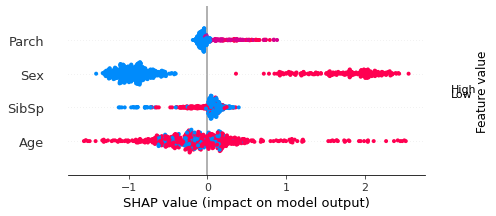

In [16]:
features = ['Parch', 'Sex', 'SibSp', 'Age']
c_shap.create_feature_shap(features)

## 3. HTML отчет

In [17]:
c_shap.create_shap_report(path_base='./shap_report')